<a href="https://colab.research.google.com/github/singhbhupender1/DataSciencePortfolio/blob/master/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
Customers churn is a very important part of ecommerce business. By keeping a customer within the service longer, companies not just able to bring in more revenue from the same customer, they can also spend less advertising money while maintaining growth.

For this churn analysis, the goal is two fold: feature extraction to identify key markers that could potentially explain why customers leave and a model that can predict possible churn customer. Predicting churn is a binary classification on inherently imbalance data. Afterall, for a prosperous business, churn will be small part of customers cohort. Here, I will also take additional steps to deal with imbalance data.

The overall outline of this analysis will be broken down as following:

1) **Data cleaning and visualization:**Exploratory data analysis with visualization;

2) **Feature ranking:**combining stability randomized logistic regression, linear model, recursive feature elimination, and xgboost to create a feature ranking matrix;

3) **Model selection:**

- compare baseline models: logistic regression, Naive Bayes, random forest, and xgboost;

- compare result with and without resampling techniques (SMOTE + Tomek);

- Tuning model parameters, and compare results of three different tuning strategy: gridsearchcv, randomizesearchcv, and evolutionsearch.

##1. Data Cleansing and Analysis

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
pd.set_option('display.max_columns',100)
%matplotlib inline

In [33]:
df = pd.read_csv('/content/churn.all.csv')
df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [34]:
print (df.shape)
print (df.isnull().any())
print (df.dtypes)

(5000, 21)
state                            False
account_length                   False
area_code                        False
phone_number                     False
intl_plan                        False
voice_mail_plan                  False
number_vmail_messages            False
total_day_minutes                False
total_day_calls                  False
total_day_charge                 False
total_eve_minutes                False
total_eve_calls                  False
total_eve_charge                 False
total_night_minutes              False
total_night_calls                False
total_night_charge               False
total_intl_minutes               False
total_intl_calls                 False
total_intl_charge                False
number_customer_service_calls    False
churned                          False
dtype: bool
state                             object
account_length                     int64
area_code                          int64
phone_number                      o

In [0]:
# Use lower case for all columns names
# Drop the "phone" column. Explanation below.
df.columns = df.columns.str.lower().str.replace(' ','_')

df.drop('phone_number', axis=1, inplace=True)


On quick inspection, the dataset looks clean without any missing value, and with a mixture of categorical, ordinal, and numerical data. With about 3300 row of data, the dataset is not big, so must algorithms will run in reasonable time with this dataset.

It is reasonable to assume the "phone" column will not provide much useful information, so we can drop it. As for the "state" column, it may contain useful information, but doing One-Hot encoding for fitting with linear model will dramatically increase the dimension of the dataset. We will determine if "state" column needed to be dropped after the feature ranking analysis.

Before we proceed further, for sake of sanity, let's check if there are any uneven distribution on the "State" columns.

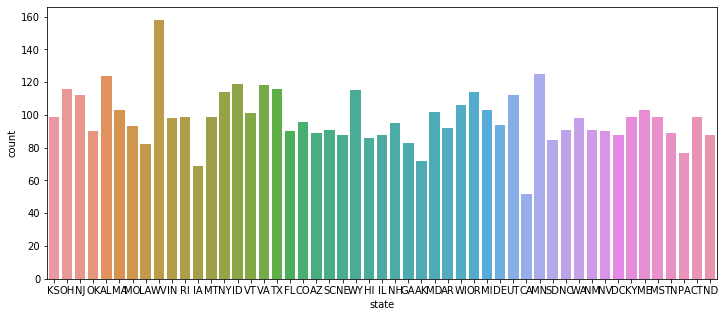

In [36]:
plt.figure(figsize=(12,5))
sns.countplot(x='state', data=df);

We see the Wisconsin has more users than any other states, and California has relatively little users with respect the population of the state. However, on the whole, nothing stands out as abnormal in this plot.

Next, let's check distribution of each variable.

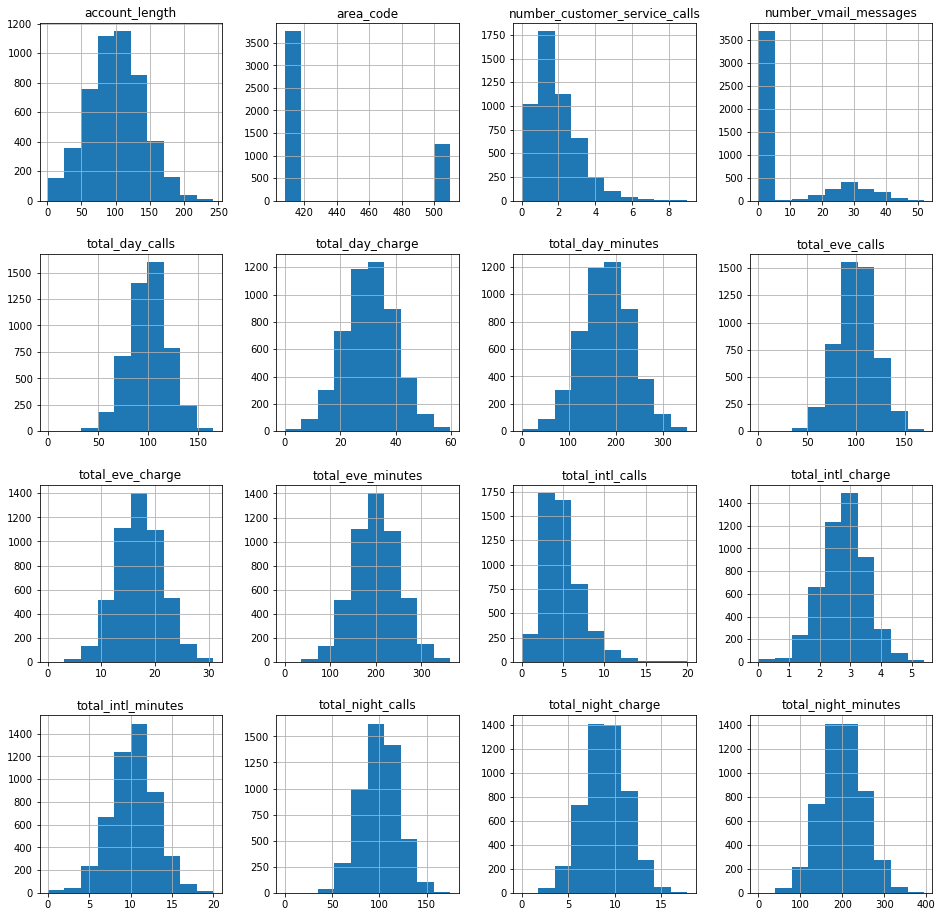

In [37]:
df.hist(figsize=(16,16));

There are nice spread for each variable, albeit that some variables have a slight skew in their distribution. Again, nothing stands out as it need additional attention.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


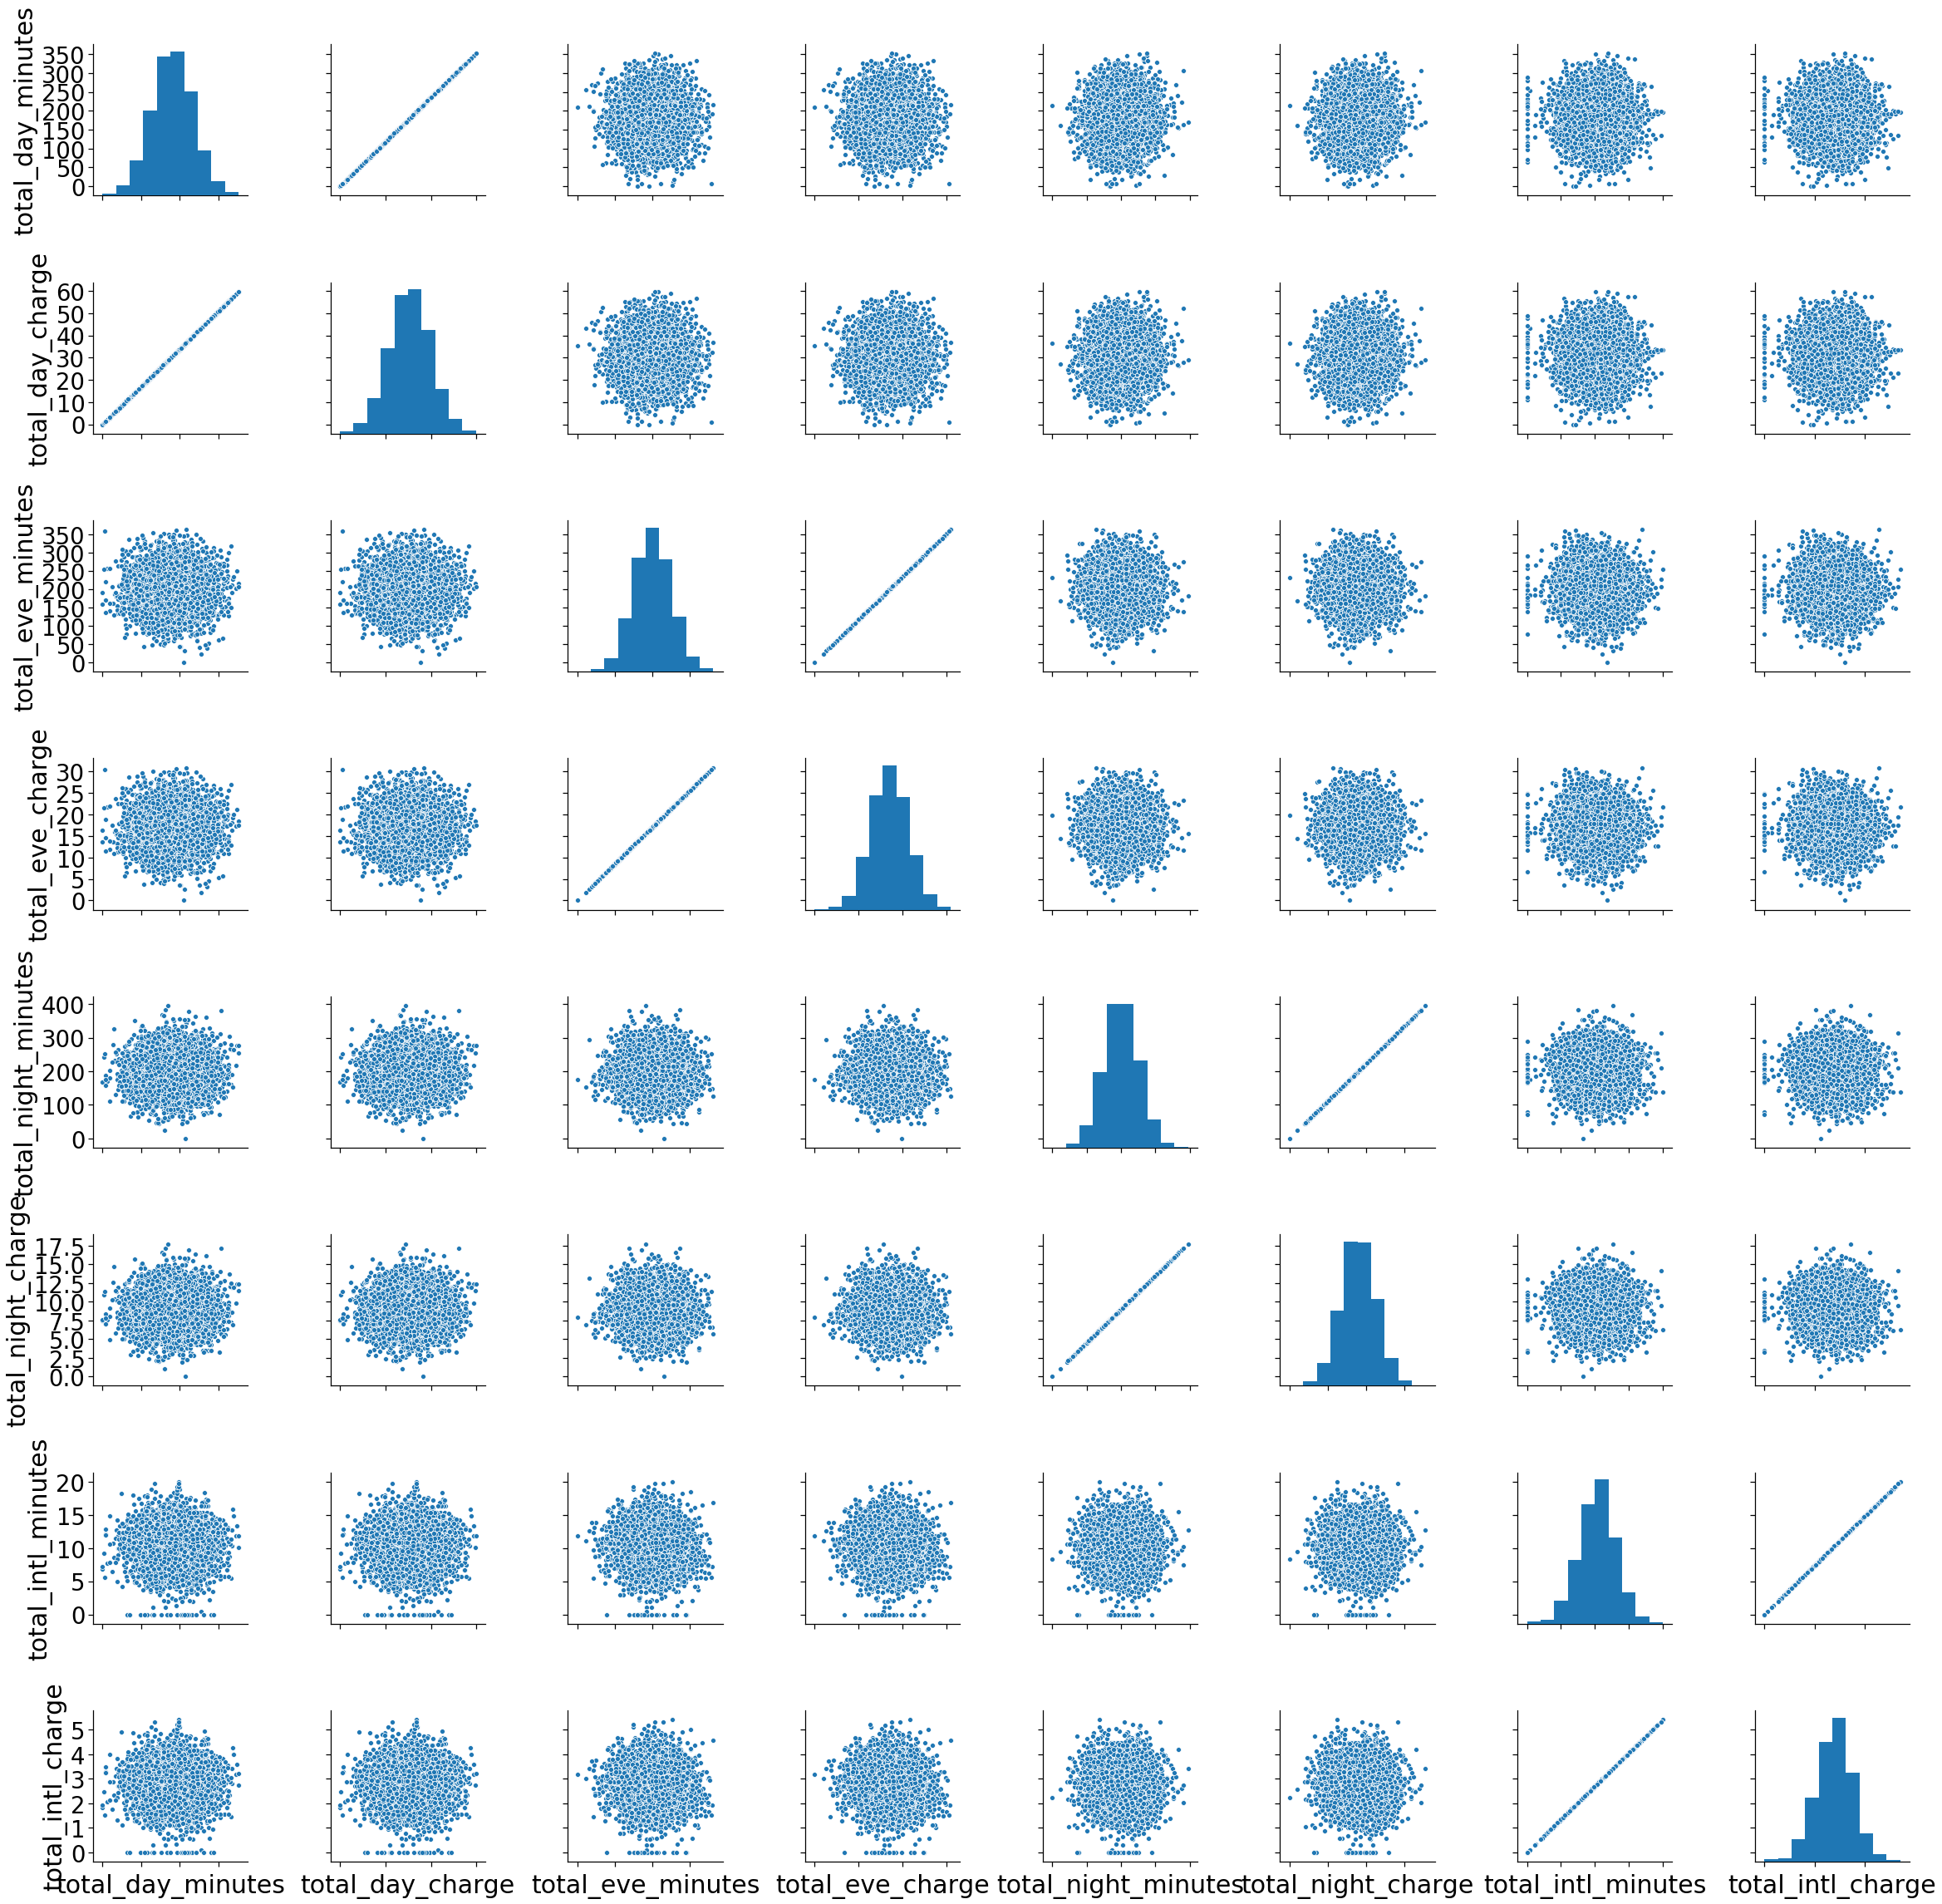

In [38]:
yes_no_col = ["intl_plan", 'voice_mail_plan']
discrete_col = ['account_length', 'number_vmail_messages', 'total_day_calls', 'total_eve_calls','total_night_calls', 
                'total_intl_calls','number_customer_service_calls']
continous_col = ['total_day_minutes','total_day_charge','total_eve_minutes','total_eve_charge','total_night_minutes','total_night_charge','total_intl_minutes','total_intl_charge']
cat_col = ['state','area_code']

with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[continous_col] ,size=4)
g.set(xticklabels=[]);

So the columns "day_charge", "eve_charge", "night_charge" and "intl_charge" are just multiple of the columns "day_mins", "eve_mins", "night_mins" and "intl_mins", respectively. We can drop all of these columns.

In [0]:
df.drop(['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'], axis=1, inplace=True)

Percentage of churn is 0.0 %


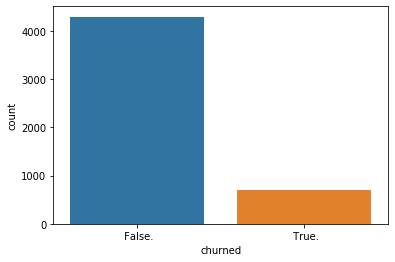

In [40]:
print ('Percentage of churn is %.1f %%'%(len(df[df['churned']=='True.'])/len(df)*100))
sns.countplot(x='churned', data = df);

As expected, the churn customers are in the minority. In this case, only 14.5% of customers turn away, which also mean that a naive approach of labeling all customers as "stay" will yield an accuracy of 85.5%. Clearly, accuracy will not be an effective measure of a model's performance. In fact, here we mostly care about recall, i.e. amongst those who churn, how many we correctly identify. Thus, f1-score and confusion matrix will be more appropriate measure of model performance.

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.dtypes[df.dtypes==object].index.values:
    df[col] = le.fit_transform(df[col])

churn_summary = df.copy()
churn_summary.drop(cat_col, axis=1, inplace=True)

churn_summary.groupby('churned').mean().T

churned,0,1
account_length,99.917074,102.332390
intl_plan,0.063825,0.281471
voice_mail_plan,0.284416,0.144272
number_vmail_messages,8.291870,4.496464
total_day_minutes,175.746564,207.870580
total_day_calls,99.899604,100.817539
total_eve_minutes,198.805031,211.757850
total_eve_calls,100.241556,99.884017
total_night_minutes,199.455113,206.078218
total_night_calls,99.975775,99.575672


There appear to be a noticable difference in mean for the variables "int'l_plan", "vmail_plan", "day_mins" and "custserv_calls". Let check these difference more closely.

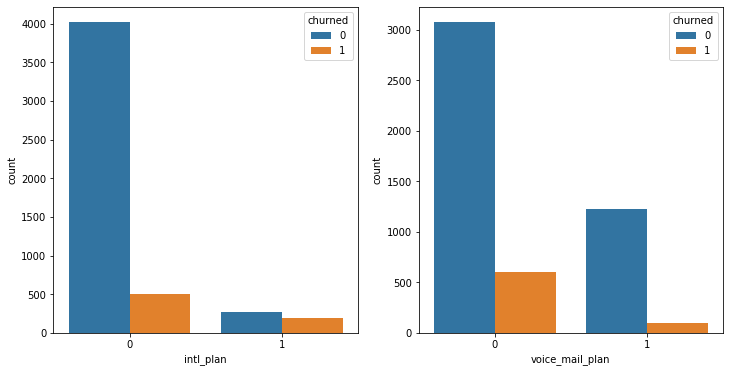

In [42]:
fig, axs = plt.subplots(ncols=len(yes_no_col), figsize=(12,6))
for i, col in enumerate(yes_no_col):
    sns.countplot(x=col, hue = 'churned',data=df, ax=axs[i])

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


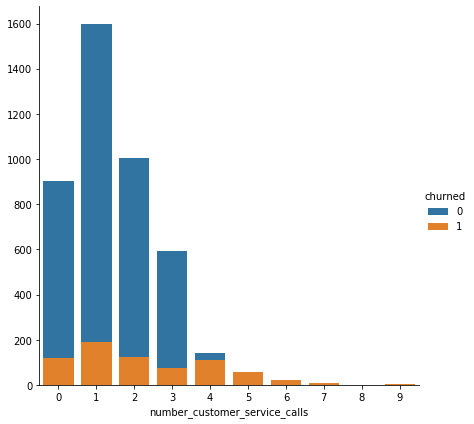

In [43]:
g = sns.FacetGrid(df, hue="churned", size=6)
g = g.map(sns.countplot, "number_customer_service_calls").add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


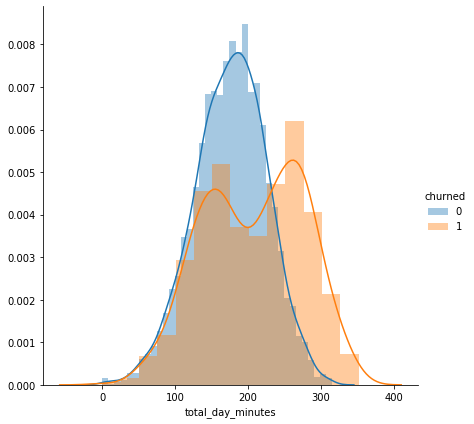

In [44]:
g = sns.FacetGrid(df, hue="churned", size=6)
g = g.map(sns.distplot, "total_day_minutes").add_legend() #kdeplot

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


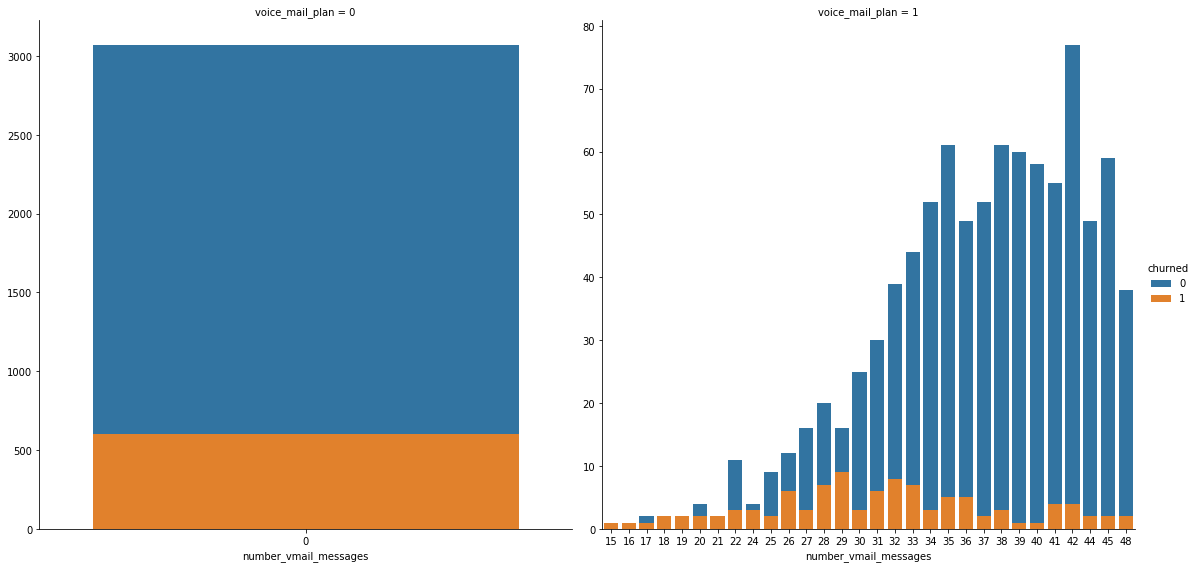

In [45]:
g = sns.FacetGrid(df, hue="churned",col='voice_mail_plan', size=8, sharex=False, sharey=False)
g = g.map(sns.countplot, "number_vmail_messages").add_legend()

Looking at each variable individually, having international plan or not having a voice messaging plan increases the likelihood of churning. Also, having at least 4 customer service calls or day minimum greater than 250 increases the likelihood of churning too.

Last, let's look at the coorelation between each variable.

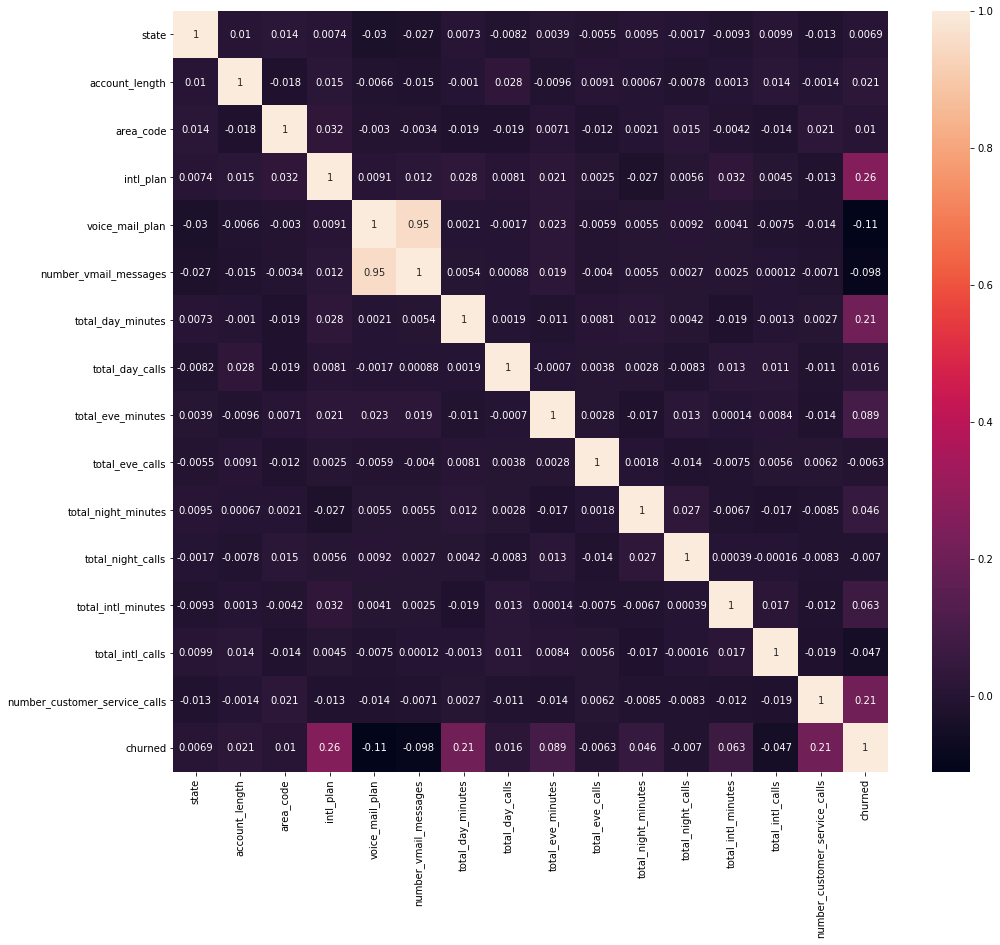

In [46]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True);

#PCA

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

# Normalize data
dataset = df.copy()
N = StandardScaler()

N.fit(dataset)

dataset_norm = N.transform(dataset)

In [0]:
# PCA
pca = PCA(n_components=2)
pca_representation = pca.fit_transform(dataset_norm)

In [0]:
# Isomap
iso = Isomap(n_components=2, n_neighbors=40)
iso_representation = iso.fit_transform(dataset_norm)

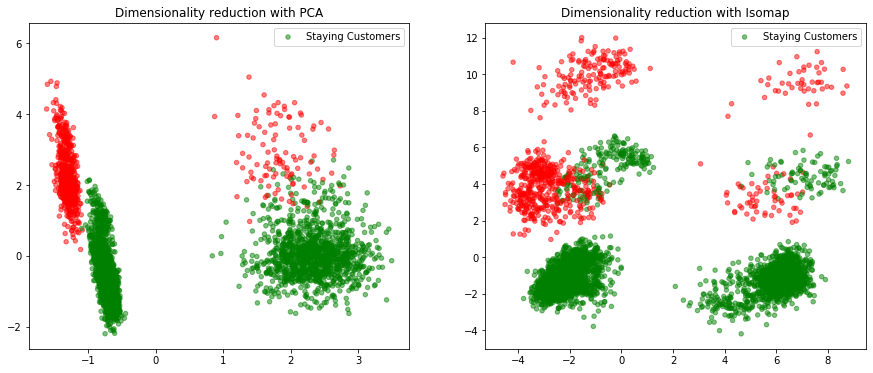

In [50]:
#Plot graph
churn_colors = dataset["churned"].map(lambda s : "g" if s==0 else "r")

fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].scatter(pca_representation[:,0],pca_representation[:,1],
            c = churn_colors,alpha=0.5,s=20)
axes[0].set_title("Dimensionality reduction with PCA")
axes[0].legend(["Staying Customers"])

axes[1].scatter(iso_representation[:,0],iso_representation[:,1],
            c = churn_colors,alpha=0.5,s=20)
axes[1].set_title("Dimensionality reduction with Isomap")
axes[1].legend(["Staying Customers"])

Relevant Links:
1)http://blog.keyrus.co.uk/a_simple_approach_to_predicting_customer_churn.html

2)https://towardsdatascience.com/predict-customer-churn-with-r-9e62357d47b4

3)http://srepho.github.io/Churn/Churn

4)https://www.kaggle.com/stevenfelix/predicting-churn/notebook

5)https://www.kaggle.com/randylaosat/predicting-employee-kernelover

Useful description on Pipeline:

https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/

Good description on feature selection:

https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models
